In [1]:
import os
import json
import numpy as np
from sklearn.metrics import roc_auc_score
from utils import compute_ece

def evaluate_metrics(model_runs, ensemble_size=16):
    """
    Evaluate metrics across multiple runs, compute averages and standard deviations.
    
    Args:
        model_runs (dict): Mapping from model labels to lists of run directories.
        ood_dataset_name (str): Name of the OOD dataset to evaluate (default: 'stl10').
    """
    metrics_summary = {}
    
    for label, run_dirs in model_runs.items():
        acc_list, nll_list, ece_list = [], [], []
        auroc_list, acc_ood_list, nll_ood_list = [], [], []
        
        for run_dir in run_dirs:
            # Load evaluation metrics
            if 'csgld' in run_dir:
                eval_path = os.path.join(run_dir, 'eval_metrics_12.json')
            else:
                eval_path = os.path.join(run_dir, f'eval_metrics_{ensemble_size}.json')
            try:
                with open(eval_path, 'r') as f:
                    em = json.load(f)
            except FileNotFoundError:
                print(f"Warning: {eval_path} not found. Skipping.")
                continue
            
            # Basic metrics
            acc = em['accuracy']
            nll = em['nll']
            
            # ECE calculation
            probs = np.array(em['probs'])
            y_true = np.array(em['y'])
            pred = np.argmax(probs, axis=1)
            correct = (y_true == pred)
            prob_correct = probs[np.arange(len(y_true)), pred]
            ece = compute_ece(correct.astype(int), prob_correct)
            
            acc_list.append(acc)
            nll_list.append(nll)
            ece_list.append(ece)
        
        # Compute averages and standard deviations
        metrics = {
            'acc': (np.mean(acc_list)), 'acc_std': np.std(acc_list),
            'nll': (np.mean(nll_list)), 'nll_std': np.std(nll_list),
            'ece': (np.mean(ece_list)), 'ece_std': np.std(ece_list),
        }
        if auroc_list:
            metrics.update({
                'acc_ood': np.mean(acc_ood_list),
                'acc_ood_std': np.std(acc_ood_list),
                'nll_ood': np.mean(nll_ood_list),
                'nll_ood_std': np.std(nll_ood_list),
            })
        
        metrics_summary[label] = metrics
    
    # Print results
    for label, metrics in metrics_summary.items():
        print(f"\n=== {label} ===")
        print(f"CIFAR-100 Accuracy: {metrics['acc']:.4f} ± {metrics['acc_std']:.4f}")
        print(f"CIFAR-100 NLL:      {metrics['nll']:.4f} ± {metrics['nll_std']:.4f}")
        print(f"CIFAR-100 ECE:      {metrics['ece']:.4f} ± {metrics['ece_std']:.4f}")

In [10]:
model_runs = {
    'SA-SGHMC': ['cifar100/ckpt_sgld/sa-sgld/S1/lr0.1_a50.0_m0.02_M2.0_r0.25'],#'cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a5.0_m0.1_M10.0_r0.25_O0.1'],
    'SGHMC': ['cifar100/ckpt_sgld/sgld/0.05/S1'],

}
evaluate_metrics(
    model_runs=model_runs,
    ensemble_size=16
)


=== SA-SGHMC ===
CIFAR-100 Accuracy: 0.7711 ± 0.0000
CIFAR-100 NLL:      0.8908 ± 0.0000
CIFAR-100 ECE:      0.0937 ± 0.0000

=== SGHMC ===
CIFAR-100 Accuracy: 0.7690 ± 0.0000
CIFAR-100 NLL:      0.9628 ± 0.0000
CIFAR-100 ECE:      0.1314 ± 0.0000


In [2]:
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from utils import compute_ece, process_train_metrics, plot_stepsize_schedule, process_eval_metrics, finalize_loss_acc_plots, plot_mi_matrices, plot_entropy_ecdfs
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,  # Set to True if you have LaTeX installed
    'font.family': 'serif',
    'mathtext.fontset': 'cm'  # Computer Modern font for math symbols
})


def evaluate_and_plot(
    model_dirs,
    ensemble_size=16,
    device=None,
    acc_positions=None
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #fig_loss, ax_loss = plt.subplots(figsize=(8,6))
    fig_acc, ax_acc = plt.subplots(figsize=(8,6))
    mi_matrices = {}
    lr_data = {}
    zeta_data = {}
    entropy_data = {}
    acc_values = {}
    calib_data = {}
    last_pred, last_y_true = None, None
    
    for label, dir_path in model_dirs.items():
        lr_entry, zeta_entry = process_train_metrics(dir_path, label, ax_acc)
        lr_data[label] = lr_entry
        zeta_data[label] = zeta_entry
        
        _, entropy, calib, ood_info, pred, y_true, acc, nll = process_eval_metrics(dir_path, label, 'ood', mi_compute=False, ensemble_size=ensemble_size)
        entropy_data[label] = entropy
        calib_data[label] = calib
        last_pred, last_y_true = pred, y_true
        acc_values[label] = acc
        print(f"{label} CIFAR-10: Acc={acc:.4f}, NLL={nll:.4f}")
        
    plot_stepsize_schedule(lr_data, acc_values, acc_positions)
    finalize_loss_acc_plots(ax_acc)
    #plot_mi_matrices(mi_matrices)
    #if last_pred is not None and last_y_true is not None:
    #    plot_entropy_ecdfs(entropy_data, last_pred, last_y_true)
    
    for label, (correct, prob_correct) in calib_data.items():
        ece = compute_ece(correct.astype(int), prob_correct)
        print(f"{label} ECE: {ece:.4f}")
    
    plt.tight_layout()
    plt.show()

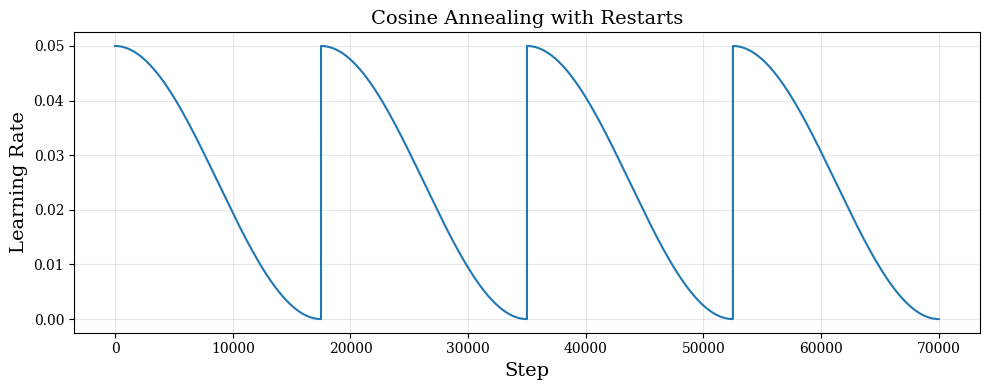

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_cycles = 4
T = 70000
lr_0 = 0.05

# Step range
x = np.arange(T)

# Cosine annealing schedule
cycle_length = T // num_cycles
cos_inner = np.pi * (x % cycle_length) / cycle_length
lr = 0.5 * (np.cos(cos_inner) + 1) * lr_0

# Plot
plt.figure(figsize=(10, 4))
plt.plot(x, lr, label='Cosine Annealing Schedule')
plt.xlabel('Step', fontsize=14)
plt.ylabel('Learning Rate', fontsize=14)
plt.title('Cosine Annealing with Restarts', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ablation on $\zeta(0)$
## Questions to answer:
### 1) Does it affect stepsize distributions?
### 2) How does it affect metrics?

SA-SGLD_zetaF CIFAR-10: Acc=0.7621, NLL=1.0210
SA-SGLD_zeta0 CIFAR-10: Acc=0.7682, NLL=1.0056
SA-SGLD_zetaF ECE: 0.1618
SA-SGLD_zeta0 ECE: 0.1619


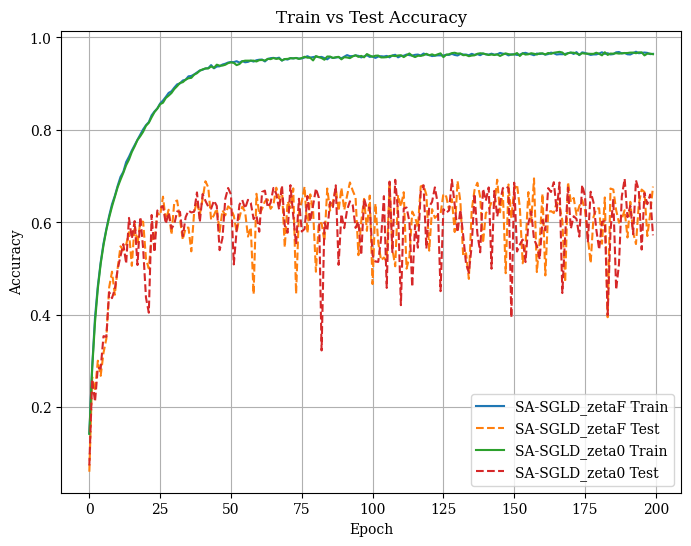

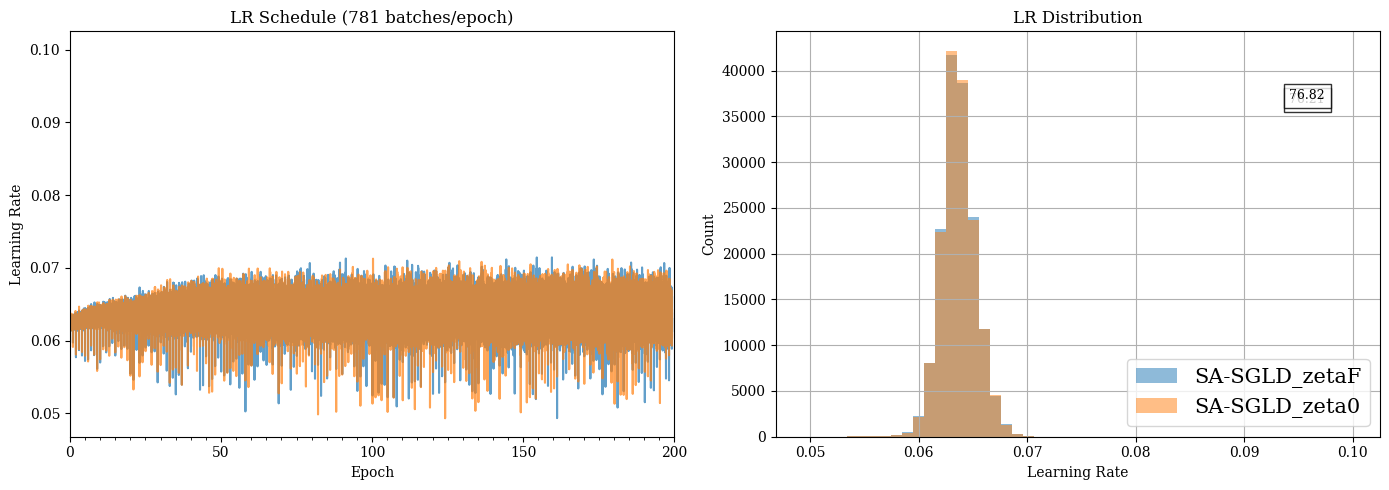

In [3]:
model_runs = {
    "SA-SGLD_zetaF":
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a50.0_m0.1_M10.0_r0.25",
    "SA-SGLD_zeta0":
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a50.0_m0.1_M10.0_r0.25_zeta0",
}

model_dirs = {'SA-SGLD_zetaF': "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a50.0_m0.1_M10.0_r0.25",
              'SA-SGLD_zeta0': "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a50.0_m0.1_M10.0_r0.25_zeta0"}
evaluate_and_plot(
    model_dirs)

# Ablation on $\alpha$ and $d\tau$
## Questions to answer:
### 1) How does it affect stepsize distributions?
### 2) How does it affect metrics?

$\alpha=0.5$ CIFAR-10: Acc=0.7626, NLL=1.0131
$\alpha=5$ CIFAR-10: Acc=0.7636, NLL=0.9481
$\alpha=50$ CIFAR-10: Acc=0.7621, NLL=1.0210
$\alpha=500$ CIFAR-10: Acc=0.7635, NLL=0.9942
$\alpha=0.5$ ECE: 0.1451
$\alpha=5$ ECE: 0.1136
$\alpha=50$ ECE: 0.1618
$\alpha=500$ ECE: 0.1486


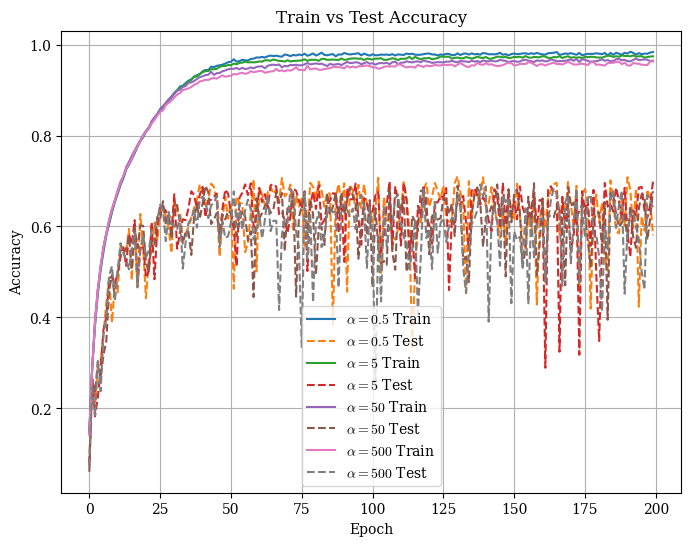

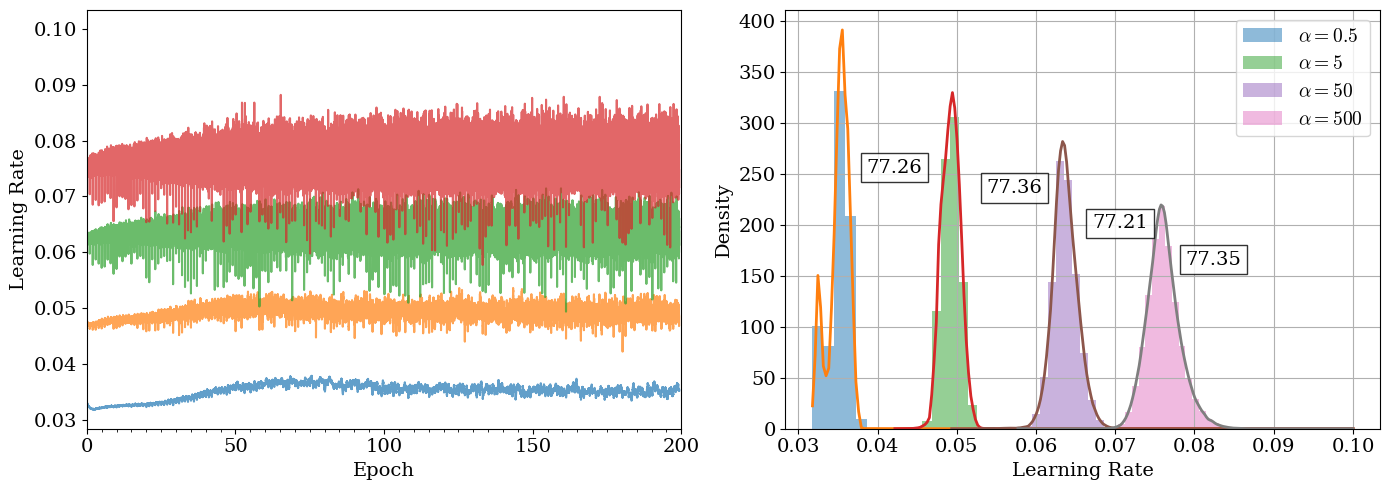

In [3]:
custom_positions = {
    r'$\alpha=0.5$': {
        'x': 0.1,
        'y': 0.8, 
        'ha': 'left',
        'va': 'top'
    },
    r'$\alpha=5$': {
        'x': 0.2,
        'y': 0.8, 
        'ha': 'left',
        'va': 'top'
    },
    r'$\alpha=50$': {
        'x': 0.35, 
        'y': 0.8,   
        'ha': 'left',
        'va': 'top'
    },
    r'$\alpha=500$': {
        'x': 0.5,
        'y': 0.8,
        'ha': 'left',
        'va': 'top'
    }
}

dirs = {
    r"$\alpha=0.5$":
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a0.5_m0.1_M10.0_r0.25",
    r"$\alpha=5$":
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a5.0_m0.1_M10.0_r0.25",
    r"$\alpha=50$":
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a50.0_m0.1_M10.0_r0.25",
    r"$\alpha=500$": "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a500.0_m0.1_M10.0_r0.25"
        }
evaluate_and_plot(dirs, acc_positions=custom_positions)

In [ ]:
dirs = {
    "SA-SGLD_dt0.001":
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.001_a50.0_m0.1_M10.0_r0.25",
    "SA-SGLD_dt0.01":
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a50.0_m0.1_M10.0_r0.25",
    "SA-SGLD_dt0.1":
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.1_a50.0_m0.1_M10.0_r0.25",
        }
evaluate_and_plot(dirs)

### Vary alpha * dtau. Confirm that the same product for different alphas and dtaus lead to the same result.
### {0.1 * 5, 0.01 * 50, 0.001 * 500}
### {0.01 * 500, 0.001 * 50}
### Vary it in the range [0.01 * 50, 0.01 * 500]

# Cyclical SGMCMC

In [13]:
model_runs = {
    "cSGLD": [
        "cifar100/ckpt_sgld/csgld/S1",
        "cifar100/ckpt_sgld/csgld/S3",
        "cifar100/ckpt_sgld/csgld/S4",
        "cifar100/ckpt_sgld/csgld/S5"
    ],
    "SA-cSGLD": [
        "cifar100/ckpt_sgld/sa-csgld/S1/a50.0_m0.1_M10.0_r0.25"
    ],
    "SA-SGLD": [
        "cifar100/ckpt_sgld/sa-sgld/S1/lr0.01_a50.0_m0.1_M10.0_r0.25_zeta0"
    ]
}
evaluate_metrics(
    model_runs=model_runs,
    ensemble_size=12
)


=== cSGLD ===
CIFAR-100 Accuracy: 0.7869 ± 0.0034
CIFAR-100 NLL:      0.9243 ± 0.0562
CIFAR-100 ECE:      0.0896 ± 0.0350

=== SA-cSGLD ===
CIFAR-100 Accuracy: 0.7895 ± 0.0000
CIFAR-100 NLL:      0.7916 ± 0.0000
CIFAR-100 ECE:      0.0241 ± 0.0000

=== SA-SGLD ===
CIFAR-100 Accuracy: 0.7663 ± 0.0000
CIFAR-100 NLL:      0.9682 ± 0.0000
CIFAR-100 ECE:      0.1226 ± 0.0000


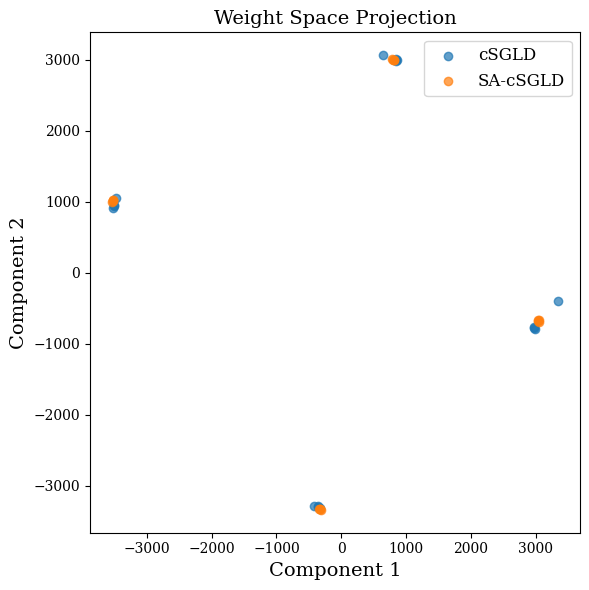

In [14]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_weight_projection(
    model_dirs,
    method="MDS",
    title="Weight Space Projection",
    random_state=0,
    n_components=2
):
    """
    Visualizes model weights using dimensionality reduction (MDS or PCA).

    Args:
        model_dirs (dict): Keys are labels (e.g., "SGD"), values are lists of directories with .pt/.pth checkpoints.
        method (str): "MDS" or "PCA"
        title (str): Plot title.
        random_state (int): Random seed for reproducibility.
        n_components (int): Number of dimensions to project down to (default: 2).
    """
    all_labels, all_coords = [], []

    for label, dir_list in model_dirs.items():
        for dir_path in dir_list:
            ckpt_files = sorted([
                f for f in os.listdir(dir_path)
                if f.endswith(('.pt', '.pth'))
            ])
            if not ckpt_files:
                print(f"Warning: No checkpoints in {dir_path}")
                continue

            weight_vecs = []
            for ckpt in ckpt_files:
                try:
                    state = torch.load(os.path.join(dir_path, ckpt), map_location='cpu')
                    sd = state.get('state_dict', state)
                    flat = np.concatenate([
                        p.detach().cpu().numpy().ravel()
                        for p in sd.values()
                        if isinstance(p, torch.Tensor)
                    ])
                    weight_vecs.append(flat)
                except Exception as e:
                    print(f"Failed to load {ckpt} in {dir_path}: {e}")
                    continue

            if len(weight_vecs) > 1:
                X = np.vstack(weight_vecs)
                X = StandardScaler().fit_transform(X)

                if method.upper() == "MDS":
                    reducer = MDS(n_components=n_components, random_state=random_state, n_init=4, max_iter=500)
                elif method.upper() == "PCA":
                    reducer = PCA(n_components=n_components, random_state=random_state)
                else:
                    raise ValueError(f"Unsupported method: {method}")

                coords = reducer.fit_transform(X)
                all_coords.append(coords)
                all_labels.append(label)

    # Plotting
    plt.figure(figsize=(6, 6))
    for label, coords in zip(all_labels, all_coords):
        plt.scatter(coords[:, 0], coords[:, 1], label=label, alpha=0.7)

    plt.title(title, fontsize=14)
    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.legend(fontsize=12)
    #plt.grid(True)
    plt.tight_layout()
    plt.show()


model_dirs = {
    "cSGLD": ["cifar100/ckpt_sgld/csgld/S1"],
    "SA-cSGLD": ["cifar100/ckpt_sgld/sa-csgld/S1/a50.0_m0.1_M10.0_r0.25"]
}
plot_weight_projection(model_dirs)

Interpolating [cSGLD]: 100%|██████████| 16/16 [00:58<00:00,  3.65s/it]


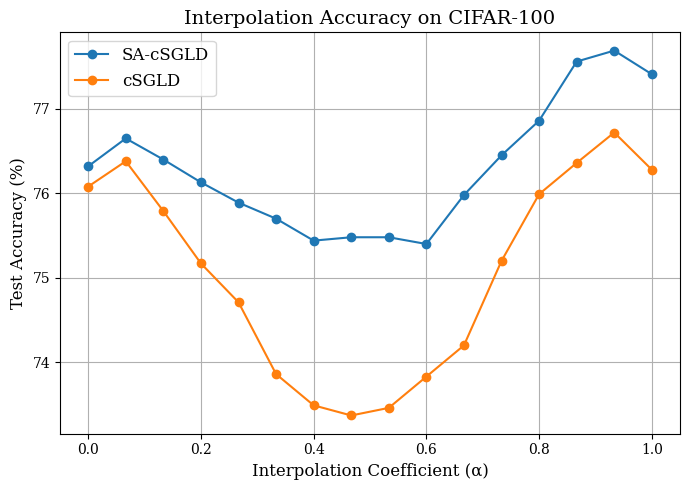

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cifar.config as cf 
from models.resnet import ResNet18

@torch.no_grad()
def evaluate_accuracy(model, dataloader, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total


def interpolate_weights(model, state_dict1, state_dict2, alpha):
    interpolated = {}
    for key in state_dict1:
        w1 = state_dict1[key]
        w2 = state_dict2[key]
        interpolated[key] = (1 - alpha) * w1 + alpha * w2
    model.load_state_dict(interpolated)


def compare_interpolation_accuracies(model_pairs, test_loader, device='cuda', steps=20):
    """
    Plots interpolation accuracy for multiple methods given a dict of checkpoint path pairs.
    """
    alphas = np.linspace(0, 1, steps)
    plt.figure(figsize=(7, 5))

    for label, (ckpt_path1, ckpt_path2) in model_pairs.items():
        model = ResNet18(num_classes=100).to(device).eval()
        sd1 = torch.load(ckpt_path1, map_location='cpu')
        sd2 = torch.load(ckpt_path2, map_location='cpu')
        state_dict1 = sd1.get('state_dict', sd1)
        state_dict2 = sd2.get('state_dict', sd2)

        accs = []
        for alpha in tqdm(alphas, desc=f"Interpolating [{label}]"):
            interpolate_weights(model, state_dict1, state_dict2, alpha)
            acc = evaluate_accuracy(model, test_loader, device=device)
            accs.append(acc)

        plt.plot(alphas, np.array(accs) * 100, marker='o', label=label)

    # Final plot formatting
    plt.title("Interpolation Accuracy on CIFAR-100", fontsize=14)
    plt.xlabel("Interpolation Coefficient (α)", fontsize=12)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean['cifar100'], cf.std['cifar100']),
])
testset = datasets.CIFAR100(root='cifar100/data', train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

model_pairs = {
    "SA-cSGLD": (
        "cifar100/ckpt_sgld/sa-csgld/S1/a50.0_m0.1_M10.0_r0.25/5.pt",
        "cifar100/ckpt_sgld/sa-csgld/S1/a50.0_m0.1_M10.0_r0.25/13.pt"
    ),
    "cSGLD": (
        "cifar100/ckpt_sgld/csgld/S1/5.pt",
        "cifar100/ckpt_sgld/csgld/S1/13.pt"
    ),
}

compare_interpolation_accuracies(model_pairs, test_loader=testloader, device='cuda', steps=16)

SA-cSGLD CIFAR-10: Acc=0.7895, NLL=0.7916
cSGLD CIFAR-10: Acc=0.7880, NLL=0.8613
SA-cSGLD ECE: 0.0241
cSGLD ECE: 0.0457


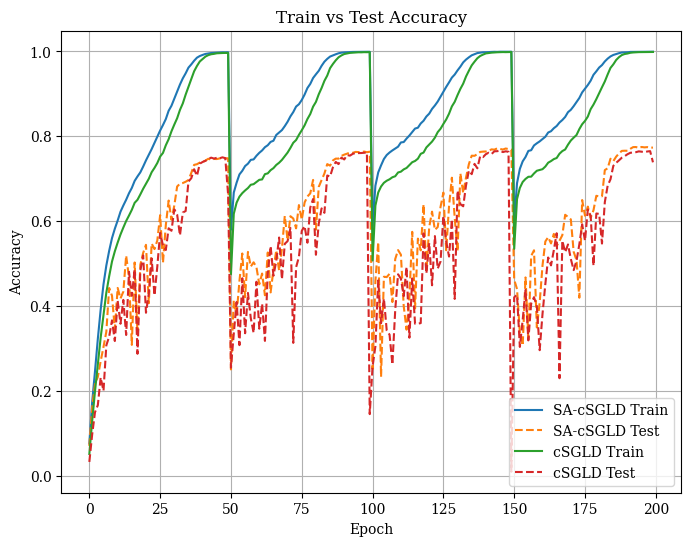

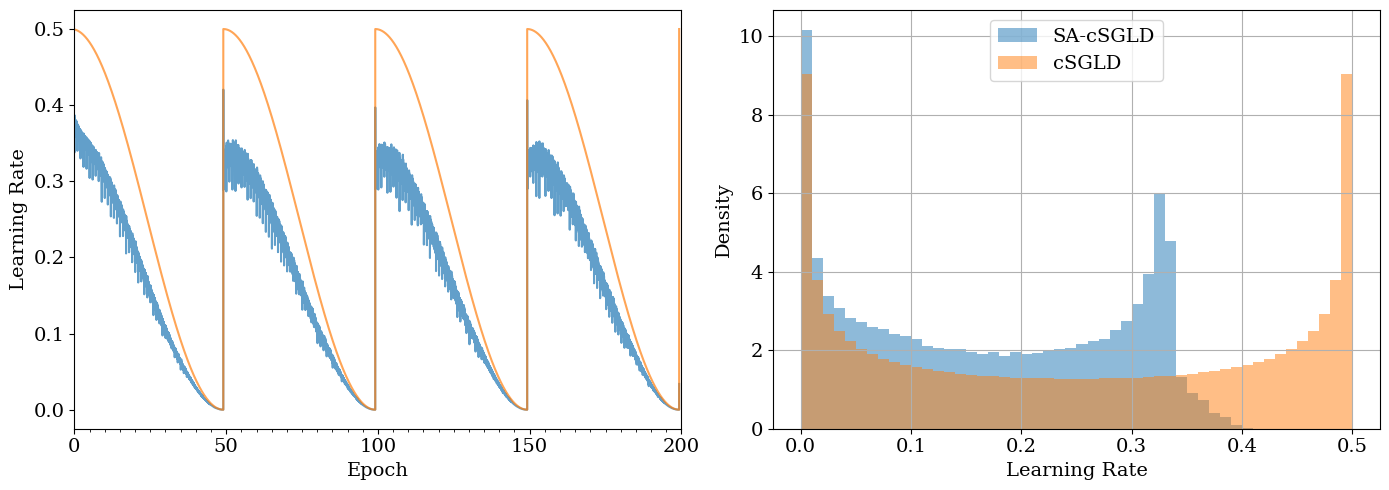

In [ ]:
dirs = {
        "SA-cSGLD":
        "cifar100/ckpt_sgld/sa-csgld/S1/a50.0_m0.1_M10.0_r0.25",
        "cSGLD": 
        "cifar100/ckpt_sgld/csgld/S2"
        }
evaluate_and_plot(dirs, ensemble_size=12)

# Deep Ensemble training
### Note: SGD, SA-SGD, SA-SGLD, Deep Ensemble SA-SGD.

In [12]:
model_runs = {
    "SA-SGD": [
        "cifar100/ckpt_desad"
    ]
}
evaluate_metrics(
    model_runs=model_runs,
    ensemble_size=2
)

evaluate_metrics(
    model_runs=model_runs,
    ensemble_size=4
)

evaluate_metrics(
    model_runs=model_runs,
    ensemble_size=8
)

evaluate_metrics(
    model_runs=model_runs,
    ensemble_size=16
)


=== SA-SGD ===
CIFAR-100 Accuracy: 0.6596 ± 0.0000
CIFAR-100 NLL:      1.3550 ± 0.0000
CIFAR-100 ECE:      0.0616 ± 0.0000

=== SA-SGD ===
CIFAR-100 Accuracy: 0.7219 ± 0.0000
CIFAR-100 NLL:      1.1114 ± 0.0000
CIFAR-100 ECE:      0.0817 ± 0.0000

=== SA-SGD ===
CIFAR-100 Accuracy: 0.7516 ± 0.0000
CIFAR-100 NLL:      1.0436 ± 0.0000
CIFAR-100 ECE:      0.1368 ± 0.0000

=== SA-SGD ===
CIFAR-100 Accuracy: 0.7766 ± 0.0000
CIFAR-100 NLL:      0.9420 ± 0.0000
CIFAR-100 ECE:      0.1500 ± 0.0000


# SGHMC

In [6]:
model_runs = {
    "SA-SGHMC": [
        "cifar100/ckpt_sghmc/sa-sghmc/S1/lr0.01_a50.0_m0.1_M10.0_r0.25",

    ],
    "SGHMC": [
        "cifar100/ckpt_sghmc/sghmc/0.063/S1",

    ]
}

evaluate_metrics(
    model_runs=model_runs,
)


=== SA-SGHMC ===
CIFAR-100 Accuracy: 0.7687 ± 0.0000
CIFAR-100 NLL:      0.9230 ± 0.0000
CIFAR-100 ECE:      0.1162 ± 0.0000

=== SGHMC ===
CIFAR-100 Accuracy: 0.7658 ± 0.0000
CIFAR-100 NLL:      0.9685 ± 0.0000
CIFAR-100 ECE:      0.1369 ± 0.0000


In [7]:
model_runs = {
    "cSGHMC": [
        "cifar100/ckpt_sghmc/csghmc/S1"
    ],
    "SA-cSGHMC": [
        "cifar100/ckpt_sghmc/sa-csghmc/S1/a50.0_m0.1_M10.0_r0.25",

    ]}
evaluate_metrics(
    model_runs=model_runs,
    ensemble_size=12
)


=== cSGHMC ===
CIFAR-100 Accuracy: 0.7880 ± 0.0000
CIFAR-100 NLL:      0.9242 ± 0.0000
CIFAR-100 ECE:      0.1020 ± 0.0000

=== SA-cSGHMC ===
CIFAR-100 Accuracy: 0.7868 ± 0.0000
CIFAR-100 NLL:      0.8432 ± 0.0000
CIFAR-100 ECE:      0.0380 ± 0.0000


SA-cSGHMC CIFAR-10: Acc=0.7868, NLL=0.8432
cSGHMC CIFAR-10: Acc=0.7880, NLL=0.9242
SA-cSGHMC ECE: 0.0380
cSGHMC ECE: 0.1020


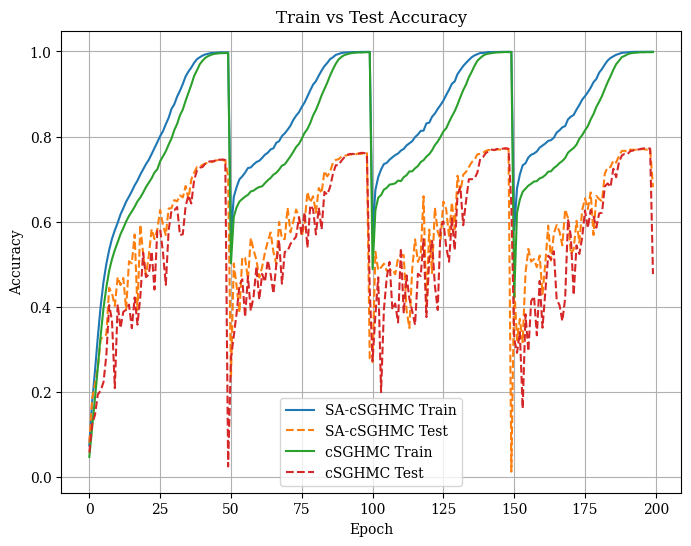

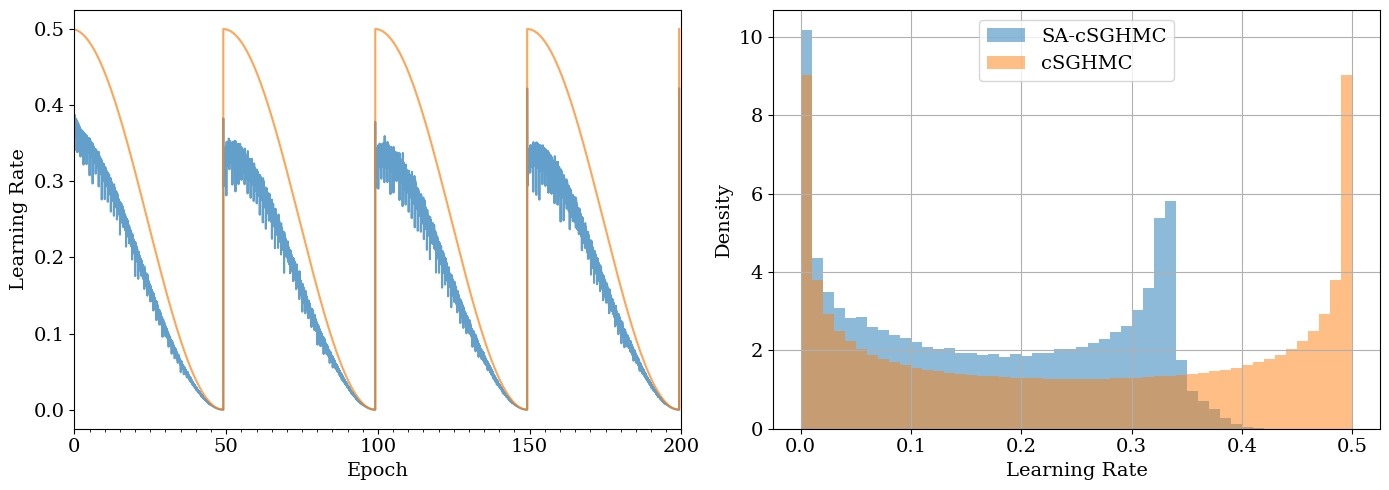

In [8]:
dirs = {
        "SA-cSGHMC":
        "cifar100/ckpt_sghmc/sa-csghmc/S1/a50.0_m0.1_M10.0_r0.25",
        "cSGHMC": 
        "cifar100/ckpt_sghmc/csghmc/S1"
        }
evaluate_and_plot(dirs, ensemble_size=12)